# Halo model power spectra
This example illustrates how to use CCL to calculate power spectra using the halo model.

In [1]:
import numpy as np
import pyccl as ccl
import pylab as plt
import matplotlib.cm as cm
from scipy.special import erf
%matplotlib inline

## Preliminaries
Generate a cosmology object and a couple of $k$ (comoving wavenumber) and $a$ (scale factor) arrays.

In [2]:
# Cosmology
cosmo = ccl.Cosmology(Omega_c=0.27, Omega_b=0.045, h=0.67, sigma8=0.83, n_s=0.96)

# Wavenumbers and scale factors
k_arr = np.geomspace(1E-4,1E1,256)
a_arr = np.linspace(0.1,1,32)


Let us also initialize a series of halo model quantities. We will need:
- A halo mass definition.
- A concentration-mass relation.
- A halo mass function parametrization.
- A halo bias parametrization.
- Halo profiles corresponding to the quantities we want to compute the power spectrum of.

In [4]:
# We will use a mass definition with Delta = 200 times the matter density
hmd_200m = ccl.halos.MassDef200m

# The Duffy 2008 concentration-mass relation
cM = ccl.halos.ConcentrationDuffy08(mass_def=hmd_200m)

# The Tinker 2008 mass function
nM = ccl.halos.MassFuncTinker08(mass_def=hmd_200m)

# The Tinker 2010 halo bias
bM = ccl.halos.HaloBiasTinker10(mass_def=hmd_200m)

# The NFW profile to characterize the matter density around halos
pM = ccl.halos.HaloProfileNFW(mass_def=hmd_200m, concentration=cM, fourier_analytic=True)

Additionally, in order to showcase the flexibility of the current halo model implementation, let us create our own halo profile characterizing the galaxy overdensity using a Halo Occupation Distribution model. We will use the same parametrization used in Nicola et al. https://arxiv.org/abs/1912.08209.

In [27]:
pg = ccl.halos.HaloProfileHOD(mass_def=hmd_200m, concentration=cM)

## Halo model power spectra

The halo-model power spectrum for two quantities defined by their halo profiles $u$ and $v$ is given by
\begin{equation}
   P_{uv}(k) = \int dM\,n(M)\,\langle u(k|M)\,v(k|M)\rangle + \left[\int dM\,n(M)\,b(M)\,\langle u(k|M)\rangle\right]\,\left[\int dM\,n(M)\,b(M)\,\langle v(k|M)\rangle\right]\,P_{\rm lin}(k).
\end{equation}

The first part, the so-called "one-halo" term, involves the Fourier-space two-point cumulant of the two profiles ($\langle u(k|M)\,v(k|M)\rangle$). This is often approximated by the product of the profile means ($\langle u(k|M)\rangle\,\langle v(k|M)\rangle$), but this is not correct in general (e.g. for the HOD profile). For this reason, the computation of the halo model power spectrum in CCL requires three main ingredients:
- The two profiles to be correlated.
- The linear matter power spectrum. Together with the profile means it controls the 2-halo term.
- The two-point cumulant of the two profiles, controlling the 1-halo term. By default we will set this to the product of the profile means, but we provide ways to define your own two-points.

Let's start by computing the different auto- and cross-correlations between matter and galaxy overdensities at $z=0$.

The first step is creating a `HMCalculator` object that essentially takes care of the mass integrals.

In [28]:
hmc = ccl.halos.HMCalculator(mass_function=nM, halo_bias=bM, mass_def=hmd_200m)

Now let's start computing the different power spectra. Note that, because we are interested in overdensities, we normalize by the means of both quantities. This is done by setting the `normprof` parameters of all method calls to `True`.

### 1. Matter-matter

In [29]:
pk_MM = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1., pM)

### 2. Galaxy-matter

In [30]:
pk_gM = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1., pg, prof2=pM)

### 3. Galaxy-galaxy

In this case we have a non-trivial two-point cumulant (see Eq. 3.9 of https://arxiv.org/abs/1909.09102). To deal with this we first create a `ProfileCovar` object that implements this.

In [36]:
# class Profile2ptHOD(ccl.halos.Profile2pt):
#     def fourier_2pt(self, cosmo, k, M, a, prof,
#                       prof2=None, mass_def=None):
#         return prof._fourier_variance(cosmo, k, M, a)
# HOD2pt = Profile2ptHOD()
    
pk_gg = ccl.halos.halomod_power_spectrum(cosmo, hmc, k_arr, 1.,
                                         pg, prof_2pt=ccl.halos.Profile2ptHOD())

OK, great, now let's plot the power spectra!

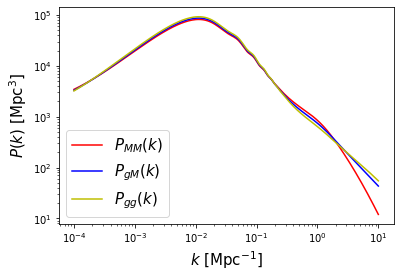

In [37]:
plt.figure()
plt.plot(k_arr, pk_MM, 'r-', label='$P_{MM}(k)$')
plt.plot(k_arr, pk_gM, 'b-', label='$P_{gM}(k)$')
plt.plot(k_arr, pk_gg, 'y-', label='$P_{gg}(k)$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', fontsize=15)
plt.ylabel(r'$P(k)\,\,[{\rm Mpc}^3]$', fontsize=15)
plt.xlabel(r'$k\,\,[{\rm Mpc}^{-1}]$', fontsize=15);

## 2D power spectra and $C_\ell$s

The `HMCalculator` objects can also provide `Pk2D` power spectrum objects that can then be used to perform Limber integrals and compute angular power spectra. Let's do so for the 3D cross correlations we just looked at.

First, let's create two CCL tracers, a `NumberCountsTracer` that we will associate with the galaxy overdensity, and a `WeakLensing` tracer that we will associate with the matter overdensity.

In [40]:
z_arr = np.linspace(0,0.5,256)
nz_arr = np.exp(-((z_arr - 0.25) / 0.05)**2)

# We give it unit bias because the HOD P(k) is already biased
t_g = ccl.NumberCountsTracer(cosmo, dndz=(z_arr, nz_arr), bias=(z_arr, np.ones_like(z_arr)), has_rsd=False)
t_M = ccl.WeakLensingTracer(cosmo, dndz=(z_arr, nz_arr))

Now let's create `Pk2D` objects for the three cross correlations

In [42]:
pk_MMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pM,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
pk_gMf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof2=pM,
                                lk_arr=np.log(k_arr), a_arr=a_arr)
pk_ggf = ccl.halos.halomod_Pk2D(cosmo, hmc, pg, prof_2pt=HOD2pt,
                                lk_arr=np.log(k_arr), a_arr=a_arr)

Now let's use these to compute $C_\ell$s

In [43]:
l_arr = np.unique(np.geomspace(2, 1000, 64).astype(int))

cl_MM = ccl.angular_cl(cosmo, t_M, t_M, l_arr, p_of_k_a=pk_MMf)
cl_gM = ccl.angular_cl(cosmo, t_g, t_M, l_arr, p_of_k_a=pk_gMf)
cl_gg = ccl.angular_cl(cosmo, t_g, t_g, l_arr, p_of_k_a=pk_ggf)


Alright, plotting time!

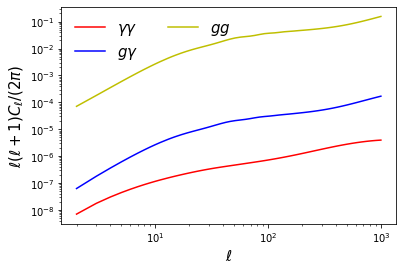

In [44]:
plt.figure()
lfac = l_arr * (l_arr + 1) / (2 * np.pi)
plt.plot(l_arr, lfac * cl_MM, 'r-', label='$\gamma\gamma$')
plt.plot(l_arr, lfac * cl_gM, 'b-', label='$g\gamma$')
plt.plot(l_arr, lfac * cl_gg, 'y-', label='$gg$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=15, ncol=2, frameon=False)
plt.ylabel(r'$\ell(\ell+1)C_\ell/(2\pi)$', fontsize=15)
plt.xlabel(r'$\ell$', fontsize=15);